In [15]:
pip install mne


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import mne
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
#dataset: Arnaud Delorme and Dean Radin (2021). Internal attention study. OpenNeuro.
#DOI: doi:10.18112/openneuro.ds002691.v1.1.0

In [37]:

data_path = "/Users/argus/Documents/first_dir/eegatt/eegatt_dataset"
subjects = [f"sub-{i:03d}" for i in range(1, 21)]
bands = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 13), "beta": (13, 30)}

for subj in subjects:
    subj_eeg_folder = os.path.join(data_path, subj, "eeg")
    set_files = [f for f in os.listdir(subj_eeg_folder) if f.endswith(".set")]
    if not set_files:
        raise FileNotFoundError(f"No .set file found in {subj_eeg_folder}")
    
    raw_file = os.path.join(subj_eeg_folder, set_files[0])
    raw = mne.io.read_raw_eeglab(raw_file, preload=True)
    
    print(f"Loaded {raw_file} successfully!")

relax_labels = [f"D{i}" for i in range(100, 183)]  # subset of D100-D182 as relax
conc_labels = [f"DI{i}" for i in range(23, 100)]  # subset of DI23-DI99 as concentrate

Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-001/eeg/sub-001_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-002/eeg/sub-002_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-003/eeg/sub-003_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-004/eeg/sub-004_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-005/eeg/sub-005_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-006/eeg/sub-006_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-007/eeg/sub-007_task-internalattention_eeg.set successfully!
Loaded /Users/argus/Documents/first_dir/eegatt/eegatt_dataset/sub-008/eeg/sub-008_task-internalattention_eeg.se

In [38]:
def extract_bandpower(epoch_data, bands, sfreq):
    psd, freqs = mne.time_frequency.psd_array_welch(
        epoch_data, sfreq=sfreq, fmin=1, fmax=40, n_fft=256
    )
    features = []
    for fmin, fmax in bands.values():
        band_power = psd[:, (freqs >= fmin) & (freqs <= fmax)].mean(axis=1)
        features.append(band_power)
    return np.concatenate(features)

In [41]:
all_X = []
all_y = []

for subj in subjects:
    # Correct path: look inside "eeg" folder
    subj_eeg_folder = os.path.join(data_path, subj, "eeg")
    
    # Find the first .set file
    set_files = [f for f in os.listdir(subj_eeg_folder) if f.endswith(".set")]
    if not set_files:
        raise FileNotFoundError(f"No .set file found in {subj_eeg_folder}")
    
    raw_file = os.path.join(subj_eeg_folder, set_files[0])
    
    # Load .set file
    raw = mne.io.read_raw_eeglab(raw_file, preload=True)

In [42]:
# events annotations inside dataset
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: [np.str_('D100'), np.str_('D101'), np.str_('D102'), np.str_('D103'), np.str_('D104'), np.str_('D105'), np.str_('D106'), np.str_('D107'), np.str_('D108'), np.str_('D109'), np.str_('D110'), np.str_('D111'), np.str_('D112'), np.str_('D113'), np.str_('D114'), np.str_('D115'), np.str_('D117'), np.str_('D119'), np.str_('D149'), np.str_('D153'), np.str_('D154'), np.str_('D155'), np.str_('D156'), np.str_('D157'), np.str_('D158'), np.str_('D159'), np.str_('D160'), np.str_('D161'), np.str_('D162'), np.str_('D163'), np.str_('D164'), np.str_('D165'), np.str_('D166'), np.str_('D167'), np.str_('D168'), np.str_('D169'), np.str_('D170'), np.str_('D171'), np.str_('D172'), np.str_('D173'), np.str_('D174'), np.str_('D175'), np.str_('D176'), np.str_('D177'), np.str_('D178'), np.str_('D179'), np.str_('D180'), np.str_('D182'), np.str_('D187'), np.str_('D211'), np.str_('D214'), np.str_('D215'), np.str_('D216'), np.str_('D217'), np.str_('D218'), np.str_('D219'), np.str_('D220'),

In [43]:
relax_event_ids = {lbl: event_id[lbl] for lbl in relax_labels if lbl in event_id}
conc_event_ids = {lbl: event_id[lbl] for lbl in conc_labels if lbl in event_id}

print("Relax IDs:", relax_event_ids)
print("Concentrate IDs:", conc_event_ids)

Relax IDs: {'D100': 1, 'D101': 2, 'D102': 3, 'D103': 4, 'D104': 5, 'D105': 6, 'D106': 7, 'D107': 8, 'D108': 9, 'D109': 10, 'D110': 11, 'D111': 12, 'D112': 13, 'D113': 14, 'D114': 15, 'D115': 16, 'D117': 17, 'D119': 18, 'D149': 19, 'D153': 20, 'D154': 21, 'D155': 22, 'D156': 23, 'D157': 24, 'D158': 25, 'D159': 26, 'D160': 27, 'D161': 28, 'D162': 29, 'D163': 30, 'D164': 31, 'D165': 32, 'D166': 33, 'D167': 34, 'D168': 35, 'D169': 36, 'D170': 37, 'D171': 38, 'D172': 39, 'D173': 40, 'D174': 41, 'D175': 42, 'D176': 43, 'D177': 44, 'D178': 45, 'D179': 46, 'D180': 47, 'D182': 48}
Concentrate IDs: {'DI23': 84, 'DI26': 85, 'DI27': 86, 'DI28': 87, 'DI29': 88, 'DI30': 89, 'DI31': 90, 'DI32': 91, 'DI33': 92, 'DI34': 93, 'DI35': 94, 'DI36': 95, 'DI37': 96, 'DI38': 97, 'DI39': 98, 'DI40': 99, 'DI41': 100, 'DI43': 101, 'DI45': 102, 'DI46': 103, 'DI47': 104, 'DI49': 105, 'DI50': 106, 'DI51': 107, 'DI53': 108, 'DI79': 109, 'DI83': 110, 'DI84': 111, 'DI86': 112, 'DI87': 113, 'DI88': 114, 'DI89': 115, 'DI

In [44]:
# Extract relax epochs (9s)
relax_epochs = mne.Epochs(raw, events, event_id=relax_event_ids,
                          tmin=0, tmax=9, baseline=None, preload=True)

Not setting metadata
407 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 407 events and 2251 original time points ...
0 bad epochs dropped


In [45]:
# for concentrate epoch
conc_epochs = mne.Epochs(raw, events, event_id=conc_event_ids,
                         tmin=0, tmax=15, baseline=None, preload=True)

Not setting metadata
221 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 221 events and 3751 original time points ...
0 bad epochs dropped


In [ ]:
#extract features

In [46]:
X, y = [], []

In [47]:
# Relax epochs
for ep in relax_epochs:
    feat = extract_bandpower(ep, bands, raw.info["sfreq"])  # ep is already a numpy array
    X.append(feat)
    y.append(0)  # Relax = 0

# Concentrate epochs
for ep in conc_epochs:
    feat = extract_bandpower(ep, bands, raw.info["sfreq"])
    X.append(feat)
    y.append(1)  # Concentrate = 1

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective wind

In [ ]:
#classifier

In [ ]:
#new

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_predict

Confusion matrix:
 [[385  22]
 [ 98 123]]

Classification report:
               precision    recall  f1-score   support

 Inattentive       0.80      0.95      0.87       407
   Attentive       0.85      0.56      0.67       221

    accuracy                           0.81       628
   macro avg       0.82      0.75      0.77       628
weighted avg       0.82      0.81      0.80       628



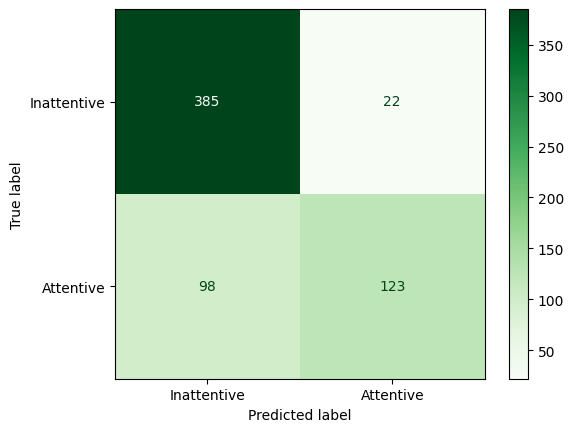

In [53]:
# Define pipeline
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get predictions for each test fold
y_pred = cross_val_predict(clf, X, y, cv=cv)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion matrix:\n", cm)

# Show classification report
print("\nClassification report:\n", classification_report(y, y_pred, target_names=["Inattentive", "Attentive"]))

# Display confusion matrix with readable labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Inattentive", "Attentive"])
disp.plot(cmap="Greens", values_format="d")
plt.show()

Confusion matrix:
 [[260 147]
 [ 91 130]]

Classification report:
               precision    recall  f1-score   support

       Relax       0.74      0.64      0.69       407
 Concentrate       0.47      0.59      0.52       221

    accuracy                           0.62       628
   macro avg       0.61      0.61      0.60       628
weighted avg       0.65      0.62      0.63       628



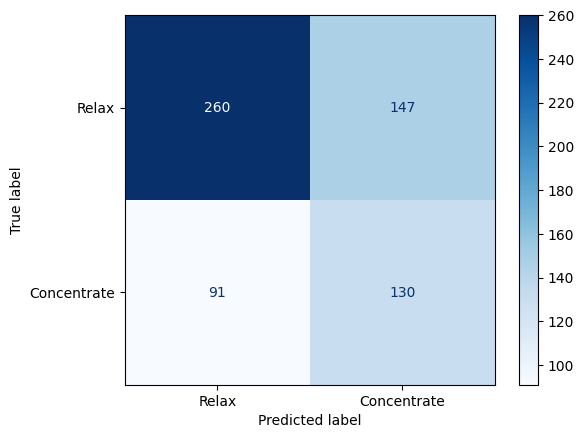

In [54]:
clf = Pipeline([
    ("scaler", StandardScaler()),  # scale features
    ("svc", SVC(kernel='linear', C=1, class_weight='balanced', random_state=42))  # linear SVM
])

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get predictions for each test fold
y_pred = cross_val_predict(clf, X, y, cv=cv)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion matrix:\n", cm)

# Show classification report
print("\nClassification report:\n", classification_report(y, y_pred, target_names=["Relax", "Concentrate"]))

# Display confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relax", "Concentrate"])
disp.plot(cmap="Blues", values_format="d")
plt.show()

In [55]:
from sklearn.linear_model import LogisticRegression

Confusion matrix:
 [[257 150]
 [ 97 124]]

Classification report:
               precision    recall  f1-score   support

       Relax       0.73      0.63      0.68       407
 Concentrate       0.45      0.56      0.50       221

    accuracy                           0.61       628
   macro avg       0.59      0.60      0.59       628
weighted avg       0.63      0.61      0.61       628



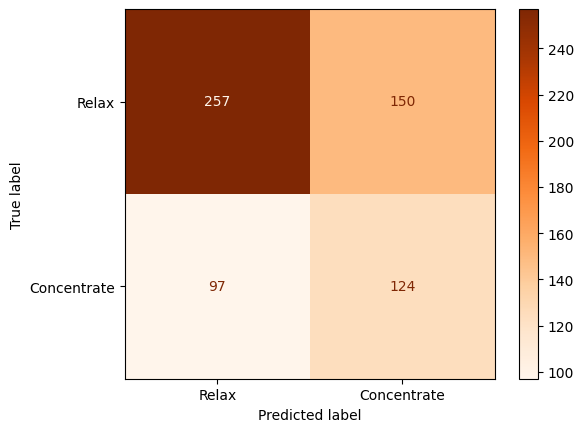

In [56]:
clf = Pipeline([
    ("scaler", StandardScaler()),  # scale features
    ("logreg", LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))
])

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get predictions for each test fold
y_pred = cross_val_predict(clf, X, y, cv=cv)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion matrix:\n", cm)

# Show classification report
print("\nClassification report:\n", classification_report(y, y_pred, target_names=["Relax", "Concentrate"]))

# Display confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relax", "Concentrate"])
disp.plot(cmap="Oranges", values_format="d")
plt.show()

In [57]:
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "SVM": SVC(kernel='linear', C=1, class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)
}

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



=== Random Forest ===
Confusion Matrix:
 [[385  22]
 [ 98 123]]

Classification Report:
               precision    recall  f1-score   support

       Relax       0.80      0.95      0.87       407
 Concentrate       0.85      0.56      0.67       221

    accuracy                           0.81       628
   macro avg       0.82      0.75      0.77       628
weighted avg       0.82      0.81      0.80       628

5-fold CV Accuracy: [0.84920635 0.82539683 0.80952381 0.784      0.776     ]
Mean CV Accuracy: 0.809


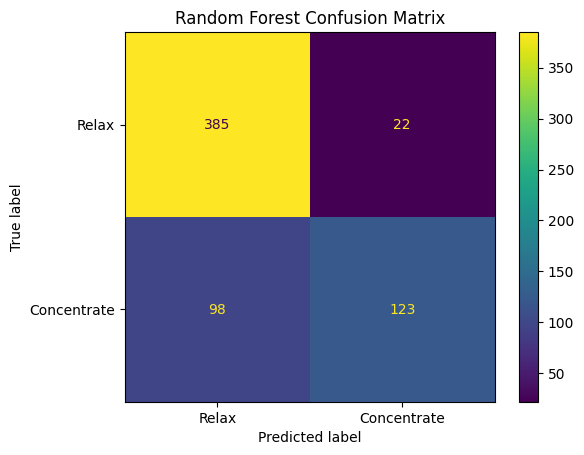


=== SVM ===
Confusion Matrix:
 [[260 147]
 [ 91 130]]

Classification Report:
               precision    recall  f1-score   support

       Relax       0.74      0.64      0.69       407
 Concentrate       0.47      0.59      0.52       221

    accuracy                           0.62       628
   macro avg       0.61      0.61      0.60       628
weighted avg       0.65      0.62      0.63       628

5-fold CV Accuracy: [0.65079365 0.62698413 0.57936508 0.64       0.608     ]
Mean CV Accuracy: 0.621


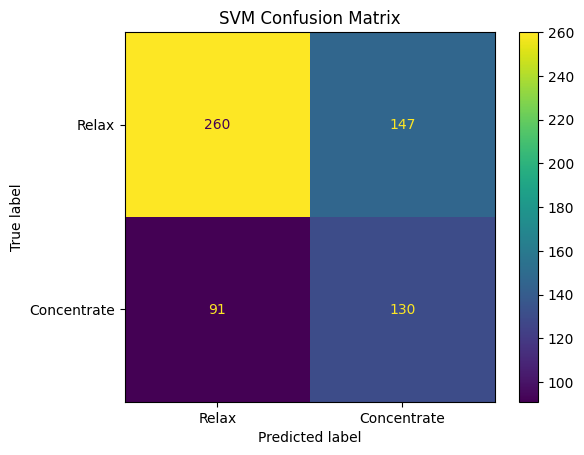


=== Logistic Regression ===
Confusion Matrix:
 [[257 150]
 [ 97 124]]

Classification Report:
               precision    recall  f1-score   support

       Relax       0.73      0.63      0.68       407
 Concentrate       0.45      0.56      0.50       221

    accuracy                           0.61       628
   macro avg       0.59      0.60      0.59       628
weighted avg       0.63      0.61      0.61       628

5-fold CV Accuracy: [0.66666667 0.62698413 0.55555556 0.632      0.552     ]
Mean CV Accuracy: 0.607


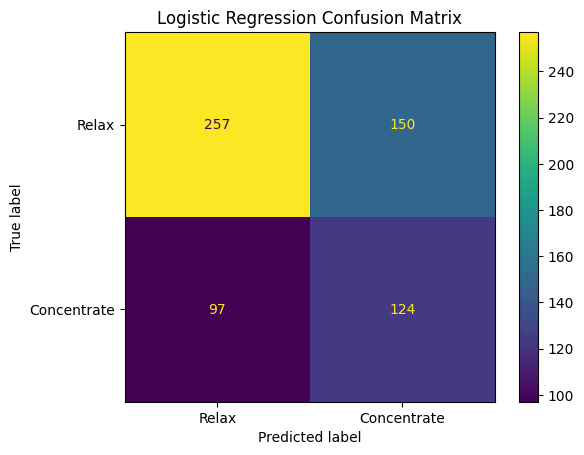

In [58]:
for name, clf_model in classifiers.items():
    print(f"\n=== {name} ===")
    
    # Create pipeline: scale + classifier
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", clf_model)
    ])
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    
    # Confusion matrix & classification report
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y, y_pred, target_names=["Relax", "Concentrate"]))
    
    # Cross-validated accuracy
    cv_scores = cross_val_score(clf, X, y, cv=cv)
    print(f"5-fold CV Accuracy: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.3f}")
    
    # Display confusion matrix visually
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relax", "Concentrate"])
    disp.plot(cmap="viridis", values_format="d")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

In [62]:
from sklearn.ensemble import VotingClassifier

In [59]:
rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
svm_clf = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
logreg_clf = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)

In [72]:
rf_pipe = Pipeline([('scaler', StandardScaler()), ('clf', rf_clf)])
svm_pipe = Pipeline([('scaler', StandardScaler()), ('clf', svm_clf)])
logreg_pipe = Pipeline([('scaler', StandardScaler()), ('clf', logreg_clf)])

In [69]:
ensemble = VotingClassifier(estimators=pipelines, voting='soft')

In [73]:
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_pipe),
        ('svm', svm_pipe),
        ('logreg', logreg_pipe)
    ],
    voting='soft',          
    weights=[2, 1, 1]       
)

In [74]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(ensemble, X, y, cv=cv)

Confusion matrix:
 [[385  22]
 [115 106]]

Classification report:
               precision    recall  f1-score   support

       Relax       0.77      0.95      0.85       407
 Concentrate       0.83      0.48      0.61       221

    accuracy                           0.78       628
   macro avg       0.80      0.71      0.73       628
weighted avg       0.79      0.78      0.76       628



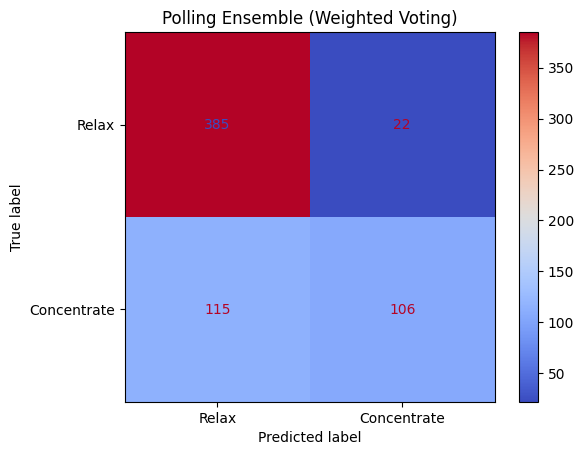

In [75]:
cm = confusion_matrix(y, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y, y_pred, target_names=["Relax", "Concentrate"]))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relax", "Concentrate"])
disp.plot(cmap="coolwarm", values_format="d")
plt.title("Polling Ensemble (Weighted Voting)")
plt.show()